Mount Google Drive

In [ ]:
from google.colab import drive

# Mount Google Drive at the specified pathm
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing

1. Extract estimated torques from CSV files \\
(Note: Estimated torques are computed using Kinematic Dynamics Library (KDL) that implements recursive Newton-Euler algorithm)

In [ ]:
import pandas as pd
import numpy as np
import random
import os

# Initialize empty lists to store estimated torques from all trajectories
Estimated_Trq = []
Estimated_Trq_data = []
trajectory_lengths = []

# Specify the path to your data csv files
csv_folder = "/content/drive/MyDrive/EECE 798K Data-Driven Modelling/Project/Data_with_estimated_trqs_CSV_form"

# Extract estimated torques columns
estimated_trq_columns = [f"estimated_trqs_{i}.txt" for i in range(1, 6)]

# Shuffle the order of trajectories for later splitting
random.seed(42)
numbers = list(range(1, 13))
random.shuffle(numbers)

for j in numbers:
  # Read the CSV file corresponding to one trajectory
  csv_file = os.path.join(csv_folder, f"traj{j}.csv")

  df = pd.read_csv(csv_file)

  # Append estimated torques to lists
  estimated_Torq_data = df[estimated_trq_columns].iloc[:-1].values
  trajectory_lengths.append(len(estimated_Torq_data))
  Estimated_Trq.append(estimated_Torq_data)


# Concatenate estimated torques from all trajectories
Estimated_Trq = np.concatenate(Estimated_Trq, axis=0)


# Print shape
print("Shape of estimated Torques:", Estimated_Trq.shape)

Shape of estimated Torques: (8501, 5)


2. Extract position, velocity, and torque data measurements from CSV files

In [ ]:
import pandas as pd
import numpy as np
import random
import os

# Initialize empty lists to store position, velocity, and torque data measurements from all trajectories
pos_data = []
vel_data = []
Pos = []
Vel = []
Trq = []
trajectory_lengths = []

# Specify the path to your data csv files
csv_folder =  "/content/drive/MyDrive/EECE 798K Data-Driven Modelling/Project/Data_with_estimated_trqs_CSV_form"

# Extract position, velocity, and torque columns
pos_columns = [f"posa{i}.txt" for i in range(1, 6)]
vel_columns = [f"vela{i}.txt" for i in range(1, 6)]
trq_columns = [f"trq{i}.txt" for i in range(1, 6)]

# Shuffle the order of trajectories for later splitting
random.seed(42)
numbers = list(range(1, 13))
random.shuffle(numbers)

for j in numbers:
  # Read the CSV file corresponding to one trajectory
  csv_file = os.path.join(csv_folder, f"traj{j}.csv")

  df = pd.read_csv(csv_file)

  # Append position, velocity, and torque data measurements to lists
  pos_data = df[pos_columns].iloc[:-1].values
  vel_data = df[vel_columns].iloc[:-1].values
  trq_data = df[trq_columns].iloc[:-1].values
  Pos.append(pos_data)
  Vel.append(vel_data)
  Trq.append(trq_data)

  # Save the length (nb of samples) of each trajectory
  trajectory_lengths.append(len(pos_data))


# Concatenate position, velocity, and torque data from all trajectories
P = np.concatenate(Pos, axis=0)
V = np.concatenate(Vel, axis=0)
T = np.concatenate(Trq, axis=0)

# Print shapes
print("Shape of matrix P:", P.shape)
print("Shape of matrix V:", V.shape)
print("Shape of matrix T:", T.shape)

Shape of matrix P: (8501, 5)
Shape of matrix V: (8501, 5)
Shape of matrix T: (8501, 5)


3. Create Data matrix from joints positions, velocities, and estimated torques and Output matrix from measured joints torques

In [ ]:
# Data matrix
Data_matrix = np.concatenate((P, V, Estimated_Trq), axis=1)
Data_matrix.shape

(8501, 15)

In [ ]:
# Output matrix
Output_matrix = T
Output_matrix.shape

(8501, 5)

In [ ]:
# length of each trajectory
trajectory_lengths

[571, 965, 547, 563, 579, 623, 513, 753, 925, 709, 1153, 600]

4. Filter the Data with a low-pass filter to get rid of noise resulting from sensors

In [ ]:
import numpy as np
from scipy.signal import butter,filtfilt


fs = 1000.0      # sample rate (Hz)
cutoff = 10      # desired cutoff frequency of the filter (Hz)
nyq = 0.5 * fs   # Nyquist Frequency (Hz)
order = 2        # signal can be approximately represented as quadratic


def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filter torque measurements
Output_matrix_filtered = np.zeros((Output_matrix.shape[0], Output_matrix.shape[1]))

for i in range(Output_matrix.shape[1]):
    Output_matrix_filtered[:, i] = butter_lowpass_filter(Output_matrix[:,i], cutoff, fs, order)

In [ ]:
# Filter position and velocity measurements
Data_matrix_filtered = np.zeros((Data_matrix.shape[0], Data_matrix.shape[1]))

for i in range(Data_matrix.shape[1]):
    Data_matrix_filtered[:, i] = butter_lowpass_filter(Data_matrix[:,i], cutoff, fs, order)

5. Visualize both original and filtered data for the five joints on a sample trajectory

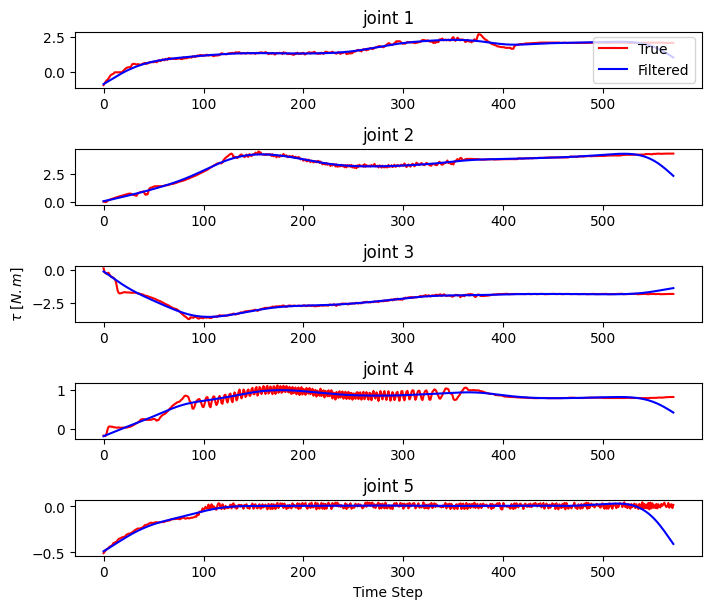

In [ ]:
# Visualize original and filtered torque data on the first trajectory

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(Output_matrix[:trajectory_lengths[0], k], label='True', color='red')
  ax.plot(Output_matrix_filtered[:trajectory_lengths[0], k], label='Filtered', color='blue')
  ax.set_title(f'joint {k+1}')

plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.show()

6. Split data into 8 trajectories for training, 2 for validation, and 2 for testing

In [ ]:
import numpy as np

# Determine the number of trajectories for each set
num_train_trajectories = 8
num_val_trajectories = 2
num_test_trajectories = 2

train_data = Data_matrix_filtered[0:5114, :]
train_output = Output_matrix_filtered[0:5114, :]

val_data = Data_matrix_filtered[5114:6748, :]
val_output = Output_matrix_filtered[5114:6748, :]

test_data = Data_matrix_filtered[6748:, :]
test_output = Output_matrix_filtered[6748:, :]

# print the number of data samples in each set
print("Shape of train set:", train_data.shape, train_output.shape)
print("Shape of validation set:", val_data.shape, val_output.shape)
print("Shape of test set:", test_data.shape, test_output.shape)

Shape of train set: (5114, 15) (5114, 5)
Shape of validation set: (1634, 15) (1634, 5)
Shape of test set: (1753, 15) (1753, 5)


# Training

1. Define a fully connected neural network (FCNN) model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, Dropout

def model():
    n_features = 15

    model = Sequential()
    model.add(Dense(128, input_shape=(n_features,), activation='relu'))  # Corrected input_shape
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(5, activation="linear"))

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model

FC_NN = model()


2. Fit the model into training data

In [ ]:
FC_NN.fit(train_data, train_output, validation_data=(val_data, val_output), epochs=50, batch_size=64)

Epoch 1/50
80/80 [==============================] - 6s 20ms/step - loss: 1.9765 - accuracy: 0.6017 - val_loss: 0.9297 - val_accuracy: 0.8758
Epoch 2/50
80/80 [==============================] - 1s 8ms/step - loss: 0.8671 - accuracy: 0.8054 - val_loss: 0.7936 - val_accuracy: 0.8403
Epoch 3/50
80/80 [==============================] - 1s 8ms/step - loss: 0.7066 - accuracy: 0.8475 - val_loss: 0.6004 - val_accuracy: 0.8446
Epoch 4/50
80/80 [==============================] - 1s 7ms/step - loss: 0.6007 - accuracy: 0.8711 - val_loss: 0.5917 - val_accuracy: 0.8501
Epoch 5/50
80/80 [==============================] - 1s 8ms/step - loss: 0.5403 - accuracy: 0.8821 - val_loss: 0.5571 - val_accuracy: 0.8556
Epoch 6/50
80/80 [==============================] - 1s 7ms/step - loss: 0.4963 - accuracy: 0.8837 - val_loss: 0.4960 - val_accuracy: 0.8605
Epoch 7/50
80/80 [==============================] - 1s 8ms/step - loss: 0.4632 - accuracy: 0.8885 - val_loss: 0.4793 - val_accuracy: 0.8678
Epoch 8/50
80/80 [=

OR: load the saved model

In [ ]:
FC_NN.load_weights('/content/drive/MyDrive/EECE 798K Data-Driven Modelling/Project/Hybrid.h5')

# Evaluation

1. Evaluate the model using MSE on train, validation, and test sets

In [ ]:
# Compute training and validation MSE
train_loss, train_mse = FC_NN.evaluate(train_data, train_output)
val_loss, val_mse = FC_NN.evaluate(val_data, val_output)

print("Train MSE:", train_loss)
print("Validation MSE:", val_loss)

52/52 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 0.9259
Train MSE: 0.04029156267642975
Validation MSE: 0.6469901204109192


In [ ]:
# Compute testing MSE
test_loss, accuracy = FC_NN.evaluate(test_data, test_output)

print("Test MSE:", test_loss)

55/55 [==============================] - 0s 8ms/step - loss: 0.9018 - accuracy: 0.8055
Test MSE: 0.9018087983131409


2. Plot the true and predicted torques on validation and test trajectories for the five joints

In [ ]:
# Predict on the validation set

val_predictions = FC_NN.predict(val_data)
val_predictions.shape

52/52 [==============================] - 0s 2ms/step


(1634, 5)

In [ ]:
# Predict on the test set

test_predictions = FC_NN.predict(test_data)
test_predictions.shape

55/55 [==============================] - 0s 2ms/step


(1753, 5)

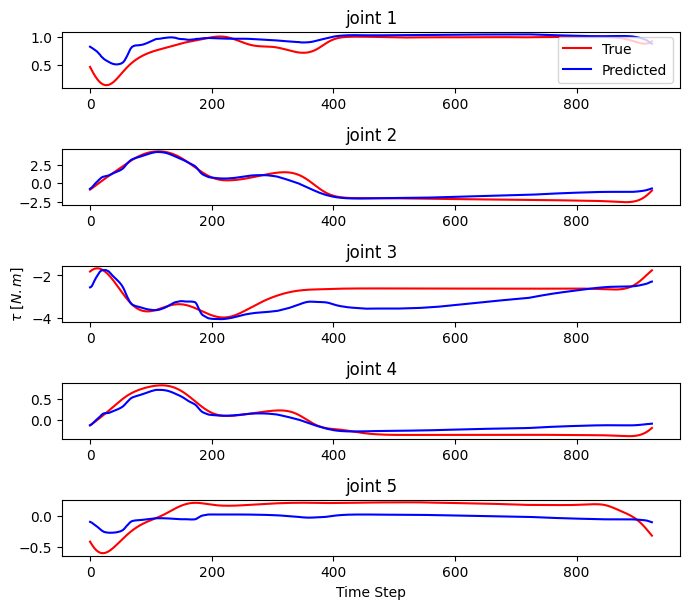

In [ ]:
# Plot the output on the first validation trajectory

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[:925, k], label='True', color='red')
  ax.plot(val_predictions[:925, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

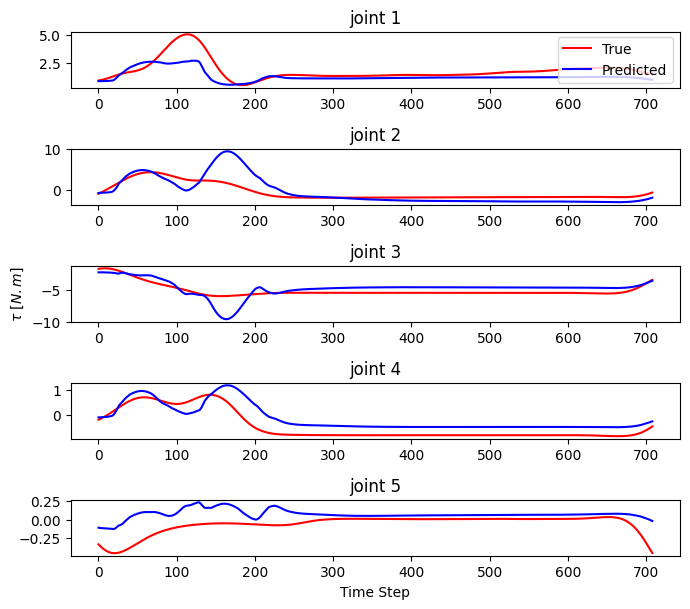

In [ ]:
# Plot the output on the second validation trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(val_output[925:, k], label='True', color='red')
  ax.plot(val_predictions[925:, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

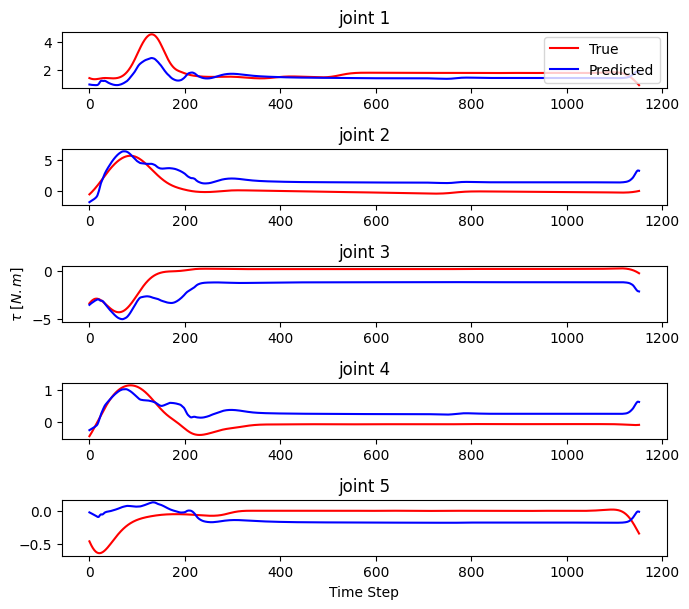

In [ ]:
# Plot the output on the first test trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[:1153, k], label='True', color='red')
  ax.plot(test_predictions[:1153, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()

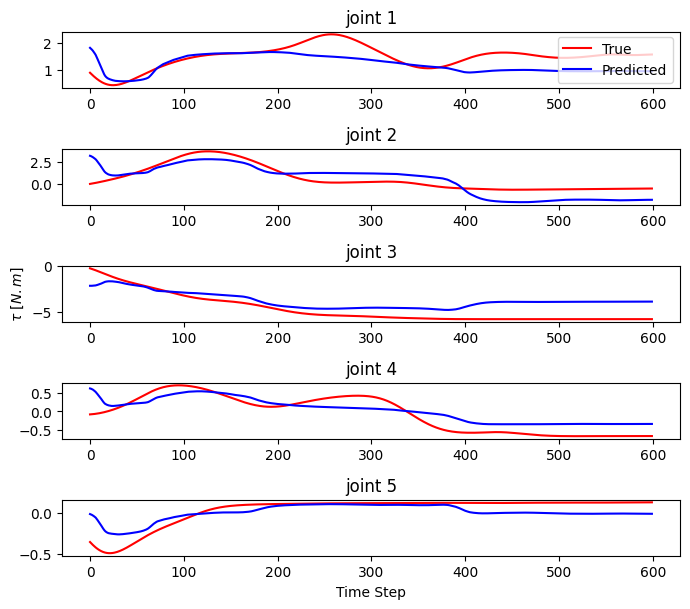

In [ ]:
# Plot the output on the second test trajectory

fig, axs = plt.subplots(5, 1, figsize=(7,6))

# Plot each output separately
for k, ax in enumerate(axs):
  ax.plot(test_output[1153:, k], label='True', color='red')
  ax.plot(test_predictions[1153:, k], label='Predicted', color='blue')
  ax.set_title(f'joint {k+1}')

axs[2].set_ylabel(r'$\tau$ [$N.m$]')
plt.tight_layout()
plt.xlabel('Time Step')
axs[0].legend(loc='right')
plt.show()


# Save the model

In [ ]:
import tensorflow as tf

# Specify the path you need to save the model into
FC_NN.save('/content/drive/MyDrive/EECE 798K Data-Driven Modelling/Project/Hybrid.h5')